In [1]:
import pandas
import numpy as np
import xarray
import matplotlib.pyplot as plt
import ulmo
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import seaborn as sns
import os
import h5py
import boto3
import cartopy

/Users/rachelstumpf/ulmo/ulmo/utils/image_utils.py:8: UserWarning: healpy not installed.  Not all functions will work!
  warnings.warn("healpy not installed.  Not all functions will work!")


In [2]:
# read data set from Nautilus files: list of 98% clear locations / dates

df = pandas.read_parquet('/Users/rachelstumpf/Documents/VIIRS_all_98clear_std.parquet')
# I want to be able to grab the file from my Aqua-1 hard drive that has equivalent latitude and longitude, 
# or maybe by id number ??

In [3]:
# need to grab date, time, and location... since dates have multiple clear images, 
# there will be multiple copies of each date from L3S data set, just at different locations
# I don't need time, can reduce to just date

extract_lat = df['lat']
extract_lon = df['lon']
extract_datetime = df['datetime']
extract_date = extract_datetime.dt.date

# to extract one row
# extract_lat[0]

In [4]:
# and I want to match this with its xarray from this date
# so first I should read in an xarray w a specific date, and what I should do is go through all of that xarray 
# date to see if it has matches in the VIIRS Table

# let's do the first date: 2012-02-01

# how do we make sure that the same spot wasn't clear at the same date at multiple times ?? 
# don't want this to be repeats within the cutouts

data_xr = xarray.open_dataset("/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/032/20120201120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc")

In [5]:
# now I want to extract pieces from VIIRS that match this time

df['date'] = df['datetime'].dt.date # this makes new column w/o time

date_extract = data_xr['time'].dt.date # this extracts the date we want from L3S
date_extract = pandas.Series(date_extract.values)
match = df[df['date'].isin(date_extract)] # this selects VIIRS rows that match L3S date

In [6]:
# extract 02-01-2012 from VIIRS table, to see if we get the same number of rows as a check, THIS WORKS !

target_date = pandas.to_datetime('2012-02-01')

filtered_df = df[(df['datetime'].dt.date == target_date.date())]

#date_array = xarray.decode_cf(data_xr)['time'].dt.date
#data_xr['time'] = date_array

In [7]:
# the match data set has all of the specific locations from that date, now we need to go through the xarray
# and extract each location that corresponds to a row in the VIIRS table

data_xr['sea_surface_temperature']

<xarray.DataArray 'sea_surface_temperature' (time: 1, lat: 9000, lon: 18000)>
[162000000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.99 89.97 89.95 89.93 ... -89.95 -89.97 -89.99
  * lon      (lon) float32 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
  * time     (time) datetime64[ns] 2012-02-01T12:00:00
Attributes:
    comment:                SST obtained by regression with buoy measurements...
    long_name:              sea surface sub-skin temperature
    source:                 NOAA
    units:                  kelvin
    standard_name:          sea_surface_subskin_temperature
    grid_mapping:           crs
    coverage_content_type:  physicalMeasurement
    valid_min:              -32767
    valid_max:              32767

In [8]:
# for each ROW in VIIRS table... take that and make it the center of the xarray cutout

pixel_num = 64
variable = data_xr['sea_surface_temperature']

results = []

for index, row in match.iterrows():
    
    centered_lat = row['lat']
    centered_lon = row['lon']
    
    lats = variable['lat'].values
    lons = variable['lon'].values
    
    center_lat = np.abs(lats-centered_lat).argmin()
    center_lon = np.abs(lons-centered_lon).argmin()
    
    start_lat = center_lat - (pixel_num // 2)
    end_lat = start_lat + pixel_num
    start_lon = center_lon - (pixel_num // 2)
    end_lon = start_lon + pixel_num
    
    subarray = variable.isel(lon = slice(start_lon, end_lon), lat = slice(start_lat, end_lat))
    nan_percentage = np.isnan(subarray.values).sum()
    
    results.append({"lat": centered_lat, "lon": centered_lon, "NaN":nan_percentage})

    #results.append(subarray)
    
results_df = pandas.DataFrame(results)

# Print the results table
print(results_df)

           lat        lon  NaN
0    19.337208 -176.89246    0
1    20.116112 -176.30530    0
2    21.009575 -175.17024    0
3    20.876402 -175.80142    0
4    20.725744 -176.50098    0
..         ...        ...  ...
816  24.445341 -154.81297    0
817  24.347338 -155.73036    0
818  24.256254 -156.53986    0
819  24.149857 -157.44040    0
820  30.722930 -171.59128    0

[821 rows x 3 columns]


In [9]:
results_df[results_df['NaN'] != 0]
66/(64*64) # even the one that may have the most masked pixels still only has 1.6% masked, this is under the 2% benchmark, as it should be

0.01611328125

In [10]:
# how to store cutouts 

xarray_list = []

pixel_num = 64
variable = data_xr['sea_surface_temperature']

for index, row in match.iterrows():
    
    centered_lat = row['lat']
    centered_lon = row['lon']
    
    lats = variable['lat'].values
    lons = variable['lon'].values
    
    center_lat = np.abs(lats-centered_lat).argmin()
    center_lon = np.abs(lons-centered_lon).argmin()
    
    start_lat = center_lat - (pixel_num // 2)
    end_lat = start_lat + pixel_num
    start_lon = center_lon - (pixel_num // 2)
    end_lon = start_lon + pixel_num
    
    subarray = variable.isel(lon = slice(start_lon, end_lon), lat = slice(start_lat, end_lat))
    subarray = subarray.assign_attrs(title = index, date = data_xr['time'].values)

    xarray_list.append(subarray)
    
    
    # in this, I also want to be able to keep their "name" column
    
   # filtered_df.loc[1278485] 

In [11]:
xarray_list[:3]

[<xarray.DataArray 'sea_surface_temperature' (time: 1, lat: 64, lon: 64)>
 [4096 values with dtype=float32]
 Coordinates:
   * lat      (lat) float32 19.97 19.95 19.93 19.91 ... 18.77 18.75 18.73 18.71
   * lon      (lon) float32 -177.5 -177.5 -177.5 -177.5 ... -176.3 -176.3 -176.3
   * time     (time) datetime64[ns] 2012-02-01T12:00:00
 Attributes:
     comment:                SST obtained by regression with buoy measurements...
     long_name:              sea surface sub-skin temperature
     source:                 NOAA
     units:                  kelvin
     standard_name:          sea_surface_subskin_temperature
     grid_mapping:           crs
     coverage_content_type:  physicalMeasurement
     valid_min:              -32767
     valid_max:              32767
     title:                  0
     date:                   ['2012-02-01T12:00:00.000000000'],
 <xarray.DataArray 'sea_surface_temperature' (time: 1, lat: 64, lon: 64)>
 [4096 values with dtype=float32]
 Coordinates:
   

In [12]:
third_feb2 = xarray_list[2].data[0,...]

#plotting.show_image(selected_xarray.data[0,...]) 
# and then what if i want to compare to te other image, can't rn because I only have the 2016 downloaded

In [13]:
cutout = match.loc[2] # this just selects the third row
cutout

filename            s3://viirs/data/2012/032/20120201001000-OSPO-L...
row                                                              3216
col                                                              2496
lat                                                         21.009575
lon                                                        -175.17024
clear_fraction                                               0.004693
field_size                                                        192
datetime                                          2012-02-01 00:10:00
ex_filename         s3://viirs/Extractions/VIIRS_2012_95clear_192x...
pp_file             s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...
pp_root                                                     viirs_std
pp_idx                                                         459126
pp_type                                                             0
mean_temperature                                            26.149899
Tmin                

<Axes: >

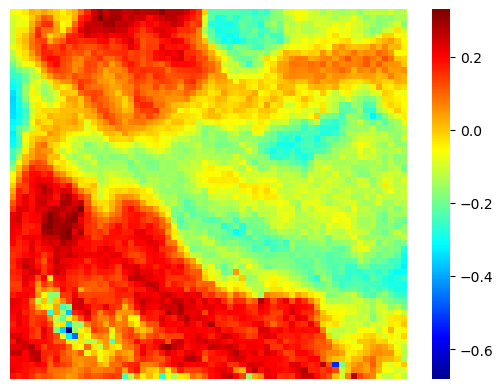

In [14]:
img = image_utils.grab_image(cutout, local_file = "/Users/rachelstumpf/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5")
plotting.show_image(img)

In [15]:
flipped_third = np.flipud(np.fliplr(xarray_list[2].data[0,...]))
mean_value = np.mean(xarray_list[2].data[0,...])  # Calculate the mean of the array
demeaned_third = flipped_third - mean_value

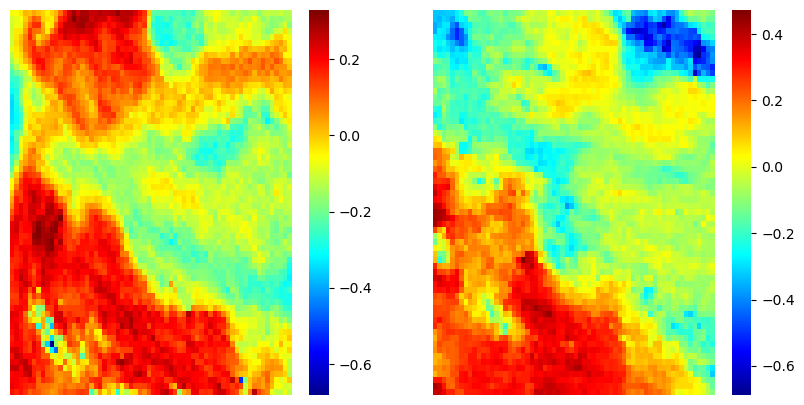

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plotting.show_image(img, ax=axes[0])

plotting.show_image(demeaned_third, ax=axes[1])

plt.show() # these do not seem to be super well matching ! 

In [18]:
# now I want to do this same process, but I want match to be created from the specific date selected
# for loop inside a for loop for date

root_folder = "/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012"
results = []

for folder_name in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, folder_name)
    
    if os.path.isdir(subfolder_path):
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            
            data_xr = xarray.open_dataset(file_path)
            
            df['date'] = df['datetime'].dt.date
            date_extract = data_xr['time'].dt.date # extracts date we want from L3S
            date_extract = pandas.Series(date_extract.values)
            match = df[df['date'].isin(date_extract)] # this selects VIIRS rows that match L3S date
            
            pixel_num = 64
            variable = data_xr['sea_surface_temperature']
            
            for index, row in match.iterrows():
                centered_lat = row['lat']
                centered_lon = row['lon']
                
                lats = variable['lat'].values
                lons = variable['lon'].values
                
                center_lat = np.abs(lats-centered_lat).argmin()
                center_lon = np.abs(lons-centered_lon).argmin()
                
                start_lat = center_lat - (pixel_num // 2)
                end_lat = start_lat + pixel_num
                start_lon = center_lon - (pixel_num // 2)
                end_lon = start_lon + pixel_num
                
                subarray = variable.isel(lon=slice(start_lon, end_lon), lat=slice(start_lat, end_lat))
                subarray = subarray.assign_attrs(date=data_xr['time'].values)
                results.append({"title": index, "subarray": subarray})
                
results_df = pandas.DataFrame(results)

# Print the results table
print(results_df)

         title                                           subarray
0            0  [[[<xarray.DataArray 'sea_surface_temperature'...
1            1  [[[<xarray.DataArray 'sea_surface_temperature'...
2            2  [[[<xarray.DataArray 'sea_surface_temperature'...
3            3  [[[<xarray.DataArray 'sea_surface_temperature'...
4            4  [[[<xarray.DataArray 'sea_surface_temperature'...
...        ...                                                ...
293937  293937  [[[<xarray.DataArray 'sea_surface_temperature'...
293938  293938  [[[<xarray.DataArray 'sea_surface_temperature'...
293939  293939  [[[<xarray.DataArray 'sea_surface_temperature'...
293940  293940  [[[<xarray.DataArray 'sea_surface_temperature'...
293941  293941  [[[<xarray.DataArray 'sea_surface_temperature'...

[293942 rows x 2 columns]


In [105]:
# this should create something with the same length as the VIIRS table with just 2012 entries

# this is not extracting cutouts at all, I just want to make sure it's grabbing the same date, centered spot, and length of VIIRS data
print(results_df.iloc[0])
# well it worked! just the formatting is weird, cause I shouldn't have saved it as a pandas.DataFrame

lat                                                 19.337208
lon                                                -176.89246
subarray    [[[<xarray.DataArray 'sea_surface_temperature'...
Name: 0, dtype: object


In [107]:
results_df.iloc[0]['subarray']

<xarray.DataArray 'sea_surface_temperature' (time: 1, lat: 64, lon: 64)>
[4096 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 19.97 19.95 19.93 19.91 ... 18.77 18.75 18.73 18.71
  * lon      (lon) float32 -177.5 -177.5 -177.5 -177.5 ... -176.3 -176.3 -176.3
  * time     (time) datetime64[ns] 2012-02-01T12:00:00
Attributes:
    comment:                SST obtained by regression with buoy measurements...
    long_name:              sea surface sub-skin temperature
    source:                 NOAA
    units:                  kelvin
    standard_name:          sea_surface_subskin_temperature
    grid_mapping:           crs
    coverage_content_type:  physicalMeasurement
    valid_min:              -32767
    valid_max:              32767
    title:                  0
    date:                   ['2012-02-01T12:00:00.000000000']

In [123]:
file_path = 'L3S_2012_preproc.h5'
with h5py.File(file_path, 'w') as f:
    valid_data = f.create_dataset('valid', (len(results_df), 1, 64, 64), dtype='float32', maxshape=(None, 1, 64, 64))
    metadata = f.create_dataset('valid_metadata', (len(results),), dtype=h5py.special_dtype(vlen=str))
    
    for title, result in enumerate(results_df):
        image = results_df.iloc[index]['subarray'].values
        date = results_df.iloc[index]['subarray']['time']
        
        valid_data[title] = image
        metadata[title] = f'Index: {title}, Date: {date}'

    # Save other metadata or attributes if needed
    f.attrs['n_imgs'] = len(results_df)

print('HDF5 file saved successfully.')

# this isn't right... still trying to figure out what all should be included in an h5 file, and how this is accessed later

HDF5 file saved successfully.


In [7]:
import h5py

root_folder = "/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012"
results = []

with h5py.File('output.h5', 'w') as hf:  # Create the HDF5 file
    subarray_list = []
    
    for folder_name in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, folder_name)
        
        if os.path.isdir(subfolder_path):
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                
                data_xr = xarray.open_dataset(file_path)
                
                df['date'] = df['datetime'].dt.date
                date_extract = data_xr['time'].dt.date
                date_extract = pandas.Series(date_extract.values)
                match = df[df['date'].isin(date_extract)]
                
                pixel_num = 64
                variable = data_xr['sea_surface_temperature']
                
                for idx, row in match.iterrows():
                    centered_lat = row['lat']
                    centered_lon = row['lon']
                    
                    lats = variable['lat'].values
                    lons = variable['lon'].values
                    
                    center_lat = np.abs(lats - centered_lat).argmin()
                    center_lon = np.abs(lons - centered_lon).argmin()
                    
                    start_lat = center_lat - (pixel_num // 2)
                    end_lat = start_lat + pixel_num
                    start_lon = center_lon - (pixel_num // 2)
                    end_lon = start_lon + pixel_num
                    
                    subarray = variable.isel(lon=slice(start_lon, end_lon), lat=slice(start_lat, end_lat))
                    subarray = subarray.assign_attrs(pp_idx=idx)
                    
                    subarray_list.append(subarray)
                    
                    results.append({"title": idx, "subarray": subarray})
    
    # Write the subarrays to 'valid' dataset in HDF5 file
    hf.create_dataset('valid', data=subarray_list)
                
results_df = pandas.DataFrame(results)

# Print the results table
print(results_df)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (293942, 1, 64) + inhomogeneous part.